In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import h5py

import torch
from torch.nn import functional as F
from torch.autograd import Variable

##############################
from models import deeplab_xception
from models import tiramisu
from models import unet
from datasets import datasets
from utils import manager as mgr
from utils import img_utils
##############################

path_dataset = "/media/philipp/DATA/dataset/dataset_3200_df_prediction_177.h5"
# set device
#device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
#exp_name = 'unet_df_030_001'
#WEIGHTS_PATH = '/home/philipp/Data/weights/'+exp_name+'/'
WEIGHTS_PATH = '/home/philipp/Code/python/edin_prediction/weights/'
device = "cuda:0"
#device = "cpu"
print(device)

architecture = 'deeplab_adj'#'deeplab'#'densenet'
nr_channels = 7
nr_classes = 4

cuda:0


In [2]:
## load model with weights

In [3]:
if architecture == 'unet':
    model = unet.UNET(in_channels=nr_channels, out_channels=nr_classes)
    weights_name = 'unet_dice_weights-19-0.217-0.821.pth'
    path = WEIGHTS_PATH + weights_name
    
elif architecture == 'densenet':
    model = tiramisu.FCDenseNet57(in_channels=nr_channels, n_classes=nr_classes)
    weights_name = 'densenet_dice_weights-3-0.186-0.808.pth'
    path = WEIGHTS_PATH + weights_name
    
elif architecture == 'deeplab':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'deeplab_dice_weights-21-0.192-0.818.pth'
    path = WEIGHTS_PATH + weights_name
    
elif architecture == 'deeplab_ce':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'deeplab_ce_weights-4-0.453-0.814.pth'
    path = WEIGHTS_PATH + weights_name
    
elif architecture == 'deeplab_adj':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'weights-22-0.175-0.836.pth'
    path = '/home/philipp/Code/work/edin_deeplab_adj/weights/' + weights_name
    
elif architecture == 'deeplab_adj_age':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'weights-18-0.103-0.892.pth'
    path = '/home/philipp/Code/work/edin_deeplab_adj_age_177/weights/' + weights_name
    
elif architecture == 'deeplab_adj_age2':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'weights-27-0.117-0.911.pth'
    path = '/home/philipp/Code/work/edin_deeplab_adj_age_177_2/weights/' + weights_name

elif architecture == 'deeplab_adj_age3':
    model = deeplab_xception.DeepLabv3_plus(nInputChannels=nr_channels, n_classes=nr_classes, os=16, pretrained=False)
    weights_name = 'weights-33-0.159-0.853.pth'
    path = '/home/philipp/Code/work/edin_deeplab_adj_age_176/weights/' + weights_name
    
else:
    print('provide architecture')
    
try:
    mgr.load_weights(model, path)
    print("weights loaded")
except:
    model.apply(mgr.weights_init)
    print("no weights found")
    
model.to(device)

model.eval()

Constructing DeepLabv3+ model...
Number of classes: 4
Output stride: 16
Number of Input Channels: 7
loading weights '/home/philipp/Code/work/edin_deeplab_adj/weights/weights-22-0.175-0.836.pth'
loaded weights (lastEpoch 21, loss 0.17506711184978485, error 0.8362130522727966)
weights loaded


DeepLabv3_plus(
  (xception_features): Xception(
    (conv1): Conv2d(7, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (rep): Sequential(
        (0): SeparableConv2d_same(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [4]:
## load dataset

In [5]:
class ForestDataset(torch.utils.data.Dataset):

    '''Characterizes a dataset for PyTorch'''

    def __init__(self, path):
        '''Initialization'''
        # open dataset
        self.dset = h5py.File(path, 'r')
        self.ortho = self.dset['ortho']
        self.dsm = self.dset['dsm']
        self.dtm = self.dset['dtm']
        self.slope = self.dset['slope']
        #self.age = self.dset['age']

        # set number of samples
        self.dataset_size = 10679

        ## TODO:
        # make means and stds load from hdf5
        self.means_tams = self.ortho.attrs['mean']
        self.stds_tams = self.ortho.attrs['sd']

        self.means_dsm = self.dsm.attrs['mean']
        self.stds_dsm = self.dsm.attrs['sd']

        self.means_dtm = self.dtm.attrs['mean']
        self.stds_dtm = self.dtm.attrs['sd']

        self.means_slope = self.slope.attrs['mean']
        self.stds_slope = self.slope.attrs['sd']
        
        #self.means_age = self.age.attrs['mean']
        #self.stds_age = self.age.attrs['sd']


    def __len__(self):
        '''Denotes the total number of samples'''
        return self.dataset_size


    def __getitem__(self, index):
        '''Generates one sample of data'''

        # depending on data change mean and std
        means = self.means_tams
        stds = self.stds_tams

        # Load data and get label
        X_ortho = (torch.tensor(self.ortho[index], \
            dtype=torch.float32).permute(2, 0, 1) - \
            means[:, np.newaxis, np.newaxis]) / stds[:, np.newaxis, np.newaxis]
        X_dsm = (torch.tensor(self.dsm[index], \
            dtype=torch.float32).permute(2, 0, 1) - self.means_dsm) / self.stds_dsm
        X_dtm = (torch.tensor(self.dtm[index], \
            dtype=torch.float32).permute(2, 0, 1) - self.means_dtm) / self.stds_dtm
        X_slope = (torch.tensor(self.slope[index], \
            dtype=torch.float32).permute(2, 0, 1) - self.means_slope) / self.stds_slope
        #X_age = (torch.tensor(self.age[index], \
        #    dtype=torch.float32).permute(2, 0, 1) - self.means_age) / self.stds_age

        X = torch.cat((X_ortho, X_dsm, X_dtm, X_slope),0)

        return X #torch.from_numpy(y).permute(2, 0, 1)


    def close(self):
        ''' closes the hdf5 file'''
        self.dset.close()


    def show_item(self, index):
        '''shows the data'''
        #plt.imshow(np.array(self.ground_truth[index]))

        fig = plt.figure(figsize=(20,20))

        dic_data = {'RGB' : [np.array(self.ortho[index][:,:,:3]), [0.1, 0.3, 0.5, 0.7]], \
        'CIR' : [np.array(np.roll(self.ortho[index], 1, axis=2)[:,:,:3]), [0.1, 0.3, 0.5, 0.7]], \
        'DSM' : [np.array(self.dsm[index].astype('f')), [10, 20, 30]], \
        'DTM' : [np.array(self.dtm[index].astype('f')), [10, 20, 30]], \
        'Slope' : [np.array(self.slope[index].astype('f')), [10, 20, 30]]}

        for i, key in enumerate(dic_data):
            ax = fig.add_subplot(2, 3, i+1)
            imgplot = plt.imshow(dic_data[key][0])
            ax.set_title(key)
            plt.colorbar(ticks=dic_data[key][1], orientation='horizontal')
            plt.axis('off')

In [6]:
## loading the dataset

# open dataset
dataset = ForestDataset(path_dataset)

In [7]:
dataset.dset.keys()

<KeysViewHDF5 ['age', 'dsm', 'dtm', 'ortho', 'slope']>

In [8]:
i = 55
dataset[0].shape

torch.Size([7, 3200, 3200])

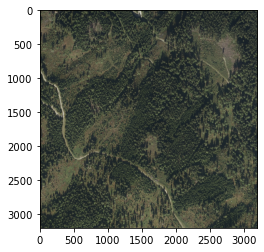

In [9]:
plt.imshow(img_utils.decode_ortho(dataset[i][0:4], 'rgb'))

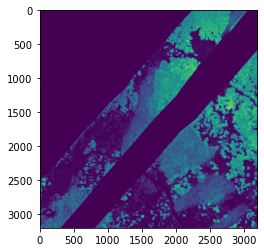

In [10]:
plt.imshow(img_utils.decode_img(dataset[i][4]))

In [11]:
def predict(store):
    # get predictions
    with torch.no_grad():
        output = model(store)
    pred_256 = mgr.get_predictions(output).numpy()
    return pred_256

In [12]:
def stack_data(dataset, idx_start, idx_end):
    dl = []
    for i in range(idx_start, idx_end):
        dl.append(dataset[i])
    return torch.stack(dl,0)

In [13]:
start = 0
end = dataset.ortho.shape[0]
batch = 1

p = np.zeros((end-start,3200,3200), dtype=np.int8)
print(p.shape)

counter = start

for i in range((end-start) // batch):
    
    print(counter, counter+batch)
    
    #store = quatering(dataset=dataset, idx_start=counter, idx_end=counter+batch)
    store = stack_data(dataset=dataset, idx_start=counter, idx_end=counter+batch)
    store = store.to(device)
    pred_512 = predict(store)
    #pred_512 = pred_512.to('cpu')
    #pred_512 = merge(pred_256, counter, counter+batch)
    
    p[i*batch:(i+1)*batch] = pred_512
    
    counter += batch
    


(782, 3200, 3200)
0 1


/home/philipp/miniconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 22
22 23
23 24
24 25
25 26
26 27
27 28
28 29
29 30
30 31
31 32
32 33
33 34
34 35
35 36
36 37
37 38
38 39
39 40
40 41
41 42
42 43
43 44
44 45
45 46
46 47
47 48
48 49
49 50
50 51
51 52
52 53
53 54
54 55
55 56
56 57
57 58
58 59
59 60
60 61
61 62
62 63
63 64
64 65
65 66
66 67
67 68
68 69
69 70
70 71
71 72
72 73
73 74
74 75
75 76
76 77
77 78
78 79
79 80
80 81
81 82
82 83
83 84
84 85
85 86
86 87
87 88
88 89
89 90
90 91
91 92
92 93
93 94
94 95
95 96
96 97
97 98
98 99
99 100
100 101
101 102
102 103
103 104
104 105
105 106
106 107
107 108
108 109
109 110
110 111
111 112
112 113
113 114
114 115
115 116
116 117
117 118
118 119
119 120
120 121
121 122
122 123
123 124
124 125
125 126
126 127
127 128
128 129
129 130
130 131
131 132
132 133
133 134
134 135
135 136
136 137
137 138
138 139
139 140
140 141
141 142
142 143
143 144
144 145
145 146
146 147
147 148
148 149
149 150
150 151
151 152
152 15

In [14]:
p.shape

(782, 3200, 3200)

In [15]:
#store = stack_data(dataset=dataset, idx_start=10640, idx_end=10660)
#store = store.to(device)
#pred_512 = predict(store)
#p[10640:10660] = pred_512

In [16]:
np.save('pred_deeplab.npy', p)

In [ ]:
##################################################################